In [1]:
import numpy as np
import pandas as pd
import requests
from pandas.io.json import json_normalize
import folium

In [66]:
CLIENT_ID = ''
CLIENT_SECRET = ''

In [3]:
VERSION = '20180604'
search_query = 'Pandora'
radius = 1000
LIMIT = 50
latitude = '45.464207'
longitude = '9.190328'

In [4]:
def search_venues(client_id, client_secret, radius, limit, query, latitude=None, longitude=None, near=None, version='20180604', simple=True, get_details=False, intent='browse', category_id='4d4b7105d754a06374d81259'):
    if near==None:
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&query={}&ll={},{}&v={}&radius={}&limit={}&intent={}&categoryId={}'.format(client_id, client_secret, query, latitude, longitude, version, radius, limit, intent, category_id)
    else:
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&query={}&near={}&v={}&radius={}&limit={}&intent={}&categoryId={}'.format(client_id, client_secret, query, near, version, radius, limit, intent, category_id)
    results = requests.get(url).json()
    venues = results['response']['venues']
    df = json_normalize(venues)
    simple_columns = ['name', 'location.lat','location.lng', 'location.city', 'categories', 'id']

    if simple:
        df = df[simple_columns]
    else:
        df = df
    if get_details:
        list_of_rows = []
        for venue in df.id.iteritems():
            tmp = get_venue_details(CLIENT_ID, CLIENT_SECRET, venue)
            list_of_rows.append(tmp)
        
        first = list_of_rows[0]
        for k, i in enumerate(list_of_rows):
            if k != 0:
                first = pd.concat([first, list_of_rows[k]], axis=0, ignore_index=True)
        first = first[['id', 'price.tier', 'hours.isOpen', 'rating']]
        df = pd.merge(df, first, on='id')
    return df

def get_venue_details(client_id, client_secret, venue_id, version='20180604'):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, client_id, client_secret, version)
    result = requests.get(url).json()
    venue = result['response']['venue']
    df = json_normalize(venue)
    return df

def get_venue_tips(client_id, client_secret, venue_id, sort='recent', limit='100', offset='0', version='20180604'):
    url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&sort={}&limit={}&offset={}'.format(venue_id, client_id, client_secret, version, sort, limit, offset)
    result = requests.get(url).json()
    tips = result['response']['tips']['items']
    df = json_normalize(tips)
    return df

# Let's scrap this, or let's keep it, but I'm not going to use it as nothing seems to be trending in Milan, or am I doing it wrong?
def get_trending_venues(client_id, client_secret, radius, limit, latitude=None, longitude=None, near=None, version='20180604', simple=True):
    if near==None:
        url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(client_id, client_secret, latitude, longitude, version, radius, limit)
    else:
        url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}'.format(client_id, client_secret, near, version, radius, limit)
    results = requests.get(url).json()
    venues = results['response']['venues']
    df = json_normalize(venues)
    simple_columns = ['name', 'location.lat','location.lng', 'location.city', 'categories', 'id']
    if simple:
        return df[simple_columns]
    else:
        return df



In [5]:
venues = search_venues(CLIENT_ID, CLIENT_SECRET, radius, LIMIT, '', latitude, longitude, get_details=False, simple=False)
venues.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,58b5d3364e31c52f888a0bed,Piazza Cordusio 3,IT,Milano,Italia,Via Orefici,335,"[Piazza Cordusio 3 (Via Orefici), 20123 Milano...","[{'label': 'display', 'lat': 45.46492026479228...",45.464920,9.186153,NaN,20123,Lombardia,Starbucks Reserve Roastery,v-1558627996,NaN
1,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",False,4b55fd64f964a520b7fa27e3,Via Santa Radegonda 16,IT,Milano,Italia,Via San Raffaele,187,"[Via Santa Radegonda 16 (Via San Raffaele), 20...","[{'label': 'display', 'lat': 45.46570727042506...",45.465707,9.191431,NaN,20121,Lombardia,Luini,v-1558627996,NaN
2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",False,52fb6e6411d2685ca74f57f0,"Via Santa Radegonda, 11",IT,Milano,Italia,NaN,175,"[Via Santa Radegonda, 11, 20121 Milano Lombard...","[{'label': 'display', 'lat': 45.46565531586118...",45.465655,9.191222,Duomo,20121,Lombardia,Spontini,v-1558627996,NaN
3,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",False,4e2e6fe31495329632fa4462,"Via San Raffaele, 6",IT,Milano,Italia,Via Santa Radegonda,185,"[Via San Raffaele, 6 (Via Santa Radegonda), 20...","[{'label': 'display', 'lat': 45.46572455316745...",45.465725,9.191307,Duomo,20121,Lombardia,Cioccolatitaliani,v-1558627996,57672473
4,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",False,5b8c17e75d891b002c1f5230,Corso Vittorio Emanuele II 37,IT,Milano,Italia,NaN,542,"[Corso Vittorio Emanuele II 37, 20122 Milano L...","[{'label': 'display', 'lat': 45.4659351288863,...",45.465935,9.196821,Duomo,20122,Lombardia,Five Guys,v-1558627996,NaN


In [6]:
#Due to having gone past the daily quota 
#get_venue_tips(CLIENT_ID, CLIENT_SECRET,'4d7a2b85ceaa224b1b620571')

# Wrong format, what now?

It seems the Nuclei di Identità Locale (quite a mouthful to say _quartiere_, that is, neighbourhood) dataset adopts the **EPSG:32632 WGS 84 / UTM zone 32N** standard.
We have to convert said set of coordinates from that standard to latitude and longitude. I adapted a solution found [here](https://gis.stackexchange.com/questions/217012/converting-utm-to-lat-long-with-a-geojson-file-in-pyproj) by using the utm library (don't reinvent the wheel, especially if there is a truckload available), thus creating the exact copy of the original geoJSON file, but with latitude and longitude instead of coordinates complying with that other standard. This was necessary to streamline operations with folium and, last but not least, to figure out **where any point on the map is in terms of Milanese neighbourhoods**. That is crucial if we want to compare neighbourhoods by looking at their venues (this way we can simply retrieve the latitude and longitude of a venue, then apply the **find_neighbourhood** function, compliant with any dictionary using the neighbourhood name as the key and the coordinates of said neighbourhood as the value of each item)


In [7]:
!pip install utm
import utm
import json
from shapely.geometry import Polygon, Point, mapping

def change_geojson_coordinates(original_filename, new_filename):
    # We will open the original file
    with open(original_filename, 'r') as f:
        data = json.load(f)
    #going through each "layer"
    for feature in data['features']:
        coords = feature['geometry']['coordinates']
        #coordList is a list of coordinates identifying each polygon
        for coordList in coords:
            #each point, expressed as a latitude, longitude pair
            for coordPair in coordList:
                #do transformation
                coordPair[0],coordPair[1] = utm.to_latlon(coordPair[0], coordPair[1], 32, 'N')
    # here is the new file
    with open(new_filename, 'w') as f:
        json.dump(data, f)

# Hats off to folium/leaflet for making this necessary, as the Milanese neighbourhoods otherwise will end up in Somalia.
def swap_geojson_coordinates(original_filename, new_filename):
    # We will open the original file
    with open(original_filename, 'r') as f:
        data = json.load(f)
    #going through each "layer"
    for feature in data['features']:
        coords = feature['geometry']['coordinates']
        #coordList is a list of coordinates identifying each polygon
        for coordList in coords:
            #each point, expressed as a latitude, longitude pair
            for coordPair in coordList:
                #do transformation
                coordPair[0],coordPair[1] = coordPair[1],coordPair[0]
    # here is the new file
    with open(new_filename, 'w') as f:
        json.dump(data, f)
        
def create_neighbourhood_dictionary(filename):
    with open(filename) as f:
        neighbourhood_dictionary = {}
        js = json.load(f)
        for feature in js['features']:
            tmp = feature['geometry']['coordinates'][0]
            tmp = [(l[0], l[1]) for l in tmp]
            neighbourhood_dictionary[feature['properties']['NIL']] = tmp
    return neighbourhood_dictionary
    
def create_neighbourhood_centres_dictionary(neigh_dict):
    neigh_centres_dict = {}
    for key, value in neigh_dict.items():
        neigh_centres_dict[key] = mapping(Polygon(value).representative_point())['coordinates']
    return neigh_centres_dict
        
        
def find_neighbourhood(neighbourhood_dict, coordinates):
    point = Point(coordinates[0], coordinates[1])
    for key, value in neighbourhood_dict.items():
        polygon = Polygon(value)
        if polygon.contains(point):
            return key
    return np.nan


change_geojson_coordinates('nilzone.geojson', 'nilzone_latlng.geojson')
# if on Kaggle change_geojson_coordinates('../input/nilzone.geojson', 'nilzone_latlng.geojson')
point = (45.464211, 9.191383) # Is the Duomo of Milan in Duomo? Though question, but the functions above will indeed help us.
NIL_coordinates = create_neighbourhood_dictionary('nilzone_latlng.geojson')  
find_neighbourhood(NIL_coordinates, point)

'DUOMO'

In [8]:
find_neighbourhood(NIL_coordinates, (45.50, 9.2))

'MACIACHINI - MAGGIOLINA'

In [9]:
pizzerias_near_duomo = search_venues(CLIENT_ID, CLIENT_SECRET, 200, 50, query='pizzeria', latitude=45.464211, longitude=9.191383, simple=False)
pizzerias_near_duomo['neighbourhood'] = np.nan
for index, row in pizzerias_near_duomo.iterrows():
    pizzerias_near_duomo.loc[index, 'neighbourhood'] = find_neighbourhood(NIL_coordinates, (pizzerias_near_duomo.loc[index, 'location.lat'], pizzerias_near_duomo.loc[index, 'location.lng']))
    
pizzerias_near_duomo

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,neighbourhood
0,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",False,52fb6e6411d2685ca74f57f0,"Via Santa Radegonda, 11",IT,Milano,Italia,161,"[Via Santa Radegonda, 11, 20121 Milano Lombard...","[{'label': 'display', 'lat': 45.46565531586118...",45.465655,9.191222,Duomo,20121,Lombardia,Spontini,v-1558627999,DUOMO
1,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",False,4dabf3ed1e72c1ab9c149ba5,"Via Conciliazione, 11",IT,Tavernola Bergamasca,Italia,187,"[Via Conciliazione, 11, Tavernola Bergamasca L...","[{'label': 'display', 'lat': 45.46556932367507...",45.465569,9.189955,NaN,NaN,Lombardia,Pizzeria L'Ancora,v-1558627999,DUOMO
2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",False,5173c71de4b03b4667525485,Italy,IT,Milano,Italia,188,"[Italy, Milano Lombardia, Italia]","[{'label': 'display', 'lat': 45.464114, 'lng':...",45.464114,9.188977,NaN,NaN,Lombardia,Pizzeria Hajri,v-1558627999,DUOMO


In [10]:
#Daily quotas again
#dsfs = get_venue_details(CLIENT_ID, CLIENT_SECRET, '4c34e5c23896e21e3258ec90')

In [11]:
swap_geojson_coordinates('nilzone_latlng.geojson', 'nilzone_lnglat.geojson')
from folium.features import Choropleth
m = folium.Map(location=[45.464211, 9.191383], tiles="cartodbdark_matter", zoom_start=13)
for i in range(0,len(pizzerias_near_duomo)):
    popup = pizzerias_near_duomo.iloc[i]['name'] #+ ', rated: ' + str(pizzerias_near_duomo.iloc[i]['rating'])
    folium.Marker([pizzerias_near_duomo.iloc[i]['location.lat'], pizzerias_near_duomo.iloc[i]['location.lng']], popup=popup).add_to(m)

Choropleth(geo_data='nilzone_lnglat.geojson', fill_color='gray', line_color='green', fill_opacity=0.4,
            line_weight=3).add_to(m)
m

In [12]:
neighbourhood_centres = create_neighbourhood_centres_dictionary(NIL_coordinates)

In [13]:
neighbourhood_centres.keys()

dict_keys(['SACCO', 'COMASINA', 'STEPHENSON', 'QT 8', 'ORTOMERCATO', 'MAGGIORE - MUSOCCO', 'PARCO LAMBRO - CIMIANO', 'GALLARATESE', 'S. SIRO', 'GHISOLFA', 'BAGGIO', 'QUARTO CAGNINO', 'LORENTEGGIO', 'GIAMBELLINO', 'S. CRISTOFORO', 'RONCHETTO SUL NAVIGLIO', 'TIBALDI', 'CASCINA TRIULZA - EXPO', 'QUARTO OGGIARO', 'AFFORI', 'PADOVA', 'EX OM - MORIVIONE', 'ADRIANO', 'FARINI', 'UMBRIA - MOLISE', 'TRIULZO SUPERIORE', 'CORSICA', "CITTA' STUDI", 'SELINUNTE', "PARCO MONLUE' - PONTE LAMBRO", "NIGUARDA - CA' GRANDA", 'STADERA', 'GUASTALLA', 'BRERA', 'DUOMO', 'SCALO ROMANA', 'MAGENTA - S. VITTORE', 'BOVISASCA', 'LODI - CORVETTO', 'LAMBRATE', 'BARONA', 'BRUZZANO', 'TRENNO', 'GRATOSOGLIO - TICINELLO', 'FIGINO', 'QUINTO ROMANO', 'PARCO AGRICOLO SUD', 'VILLAPIZZONE', 'BOVISA', 'DERGANO', 'PARCO NORD', 'BICOCCA', 'MUGGIANO', 'PORTELLO', 'TRE TORRI', 'PARCO SEMPIONE', 'GIARDINI PORTA VENEZIA', 'TORTONA', 'NAVIGLI', 'XXII MARZO', 'BUENOS AIRES - VENEZIA', 'QUINTOSOLE', 'RONCHETTO DELLE RANE', 'CHIARAVALLE'

In [14]:
centres_map = folium.Map(location=[45.464211, 9.191383], tiles="cartodbdark_matter", zoom_start=13)
for key, val in neighbourhood_centres.items():
    popup = key #+ ', rated: ' + str(neighbourhood_venues.iloc[i]['rating'])
    folium.Marker([val[0], val[1]], popup=popup).add_to(centres_map)


Choropleth(geo_data='nilzone_lnglat.geojson', fill_color='gray', line_color='green', fill_opacity=0.4,
            line_weight=3).add_to(centres_map)
centres_map

In [15]:
from folium.plugins import MarkerCluster

complete_map = folium.Map(location=[45.464211, 9.191383], tiles="cartodbdark_matter", zoom_start=13)


city_centre_centres = {}
columns = []

for key, val in neighbourhood_centres.items():
    if key in ['DUOMO', 'VIGENTINA', 'TICINESE', 'MAGENTA - S. VITTORE', 'BRERA', 'GUASTALLA', 'GIARDINI PORTA VENEZIA', 'AFFORI']:
        city_centre_centres[key] = val

for key, val in neighbourhood_centres.items():
    cluster = MarkerCluster()
    cluster.add_to(complete_map)
    neighbourhood_venues = search_venues(CLIENT_ID, CLIENT_SECRET, 300, 50, query='', latitude=val[0], longitude=val[1], simple=False)
    neighbourhood_venues['neighbourhood'] = np.nan
    columns = neighbourhood_venues.columns
    for index, row in neighbourhood_venues.iterrows():
        neighbourhood_venues.loc[index, 'neighbourhood'] = find_neighbourhood(NIL_coordinates, (neighbourhood_venues.loc[index, 'location.lat'], neighbourhood_venues.loc[index, 'location.lng']))
    for i in range(0,len(neighbourhood_venues)):
        popup = neighbourhood_venues.iloc[i]['name'] #+ ', rated: ' + str(neighbourhood_venues.iloc[i]['rating'])
        folium.Marker([neighbourhood_venues.iloc[i]['location.lat'], neighbourhood_venues.iloc[i]['location.lng']], popup=popup).add_to(cluster)


Choropleth(geo_data='nilzone_lnglat.geojson', fill_color='gray', line_color='green', fill_opacity=0.4,
            line_weight=3).add_to(complete_map)
complete_map

In [16]:
val = neighbourhood_centres['AFFORI']
#print(val)
neighbourhood_venues = search_venues(CLIENT_ID, CLIENT_SECRET, 200, 50, query='food', latitude=str(val[0]), longitude=str(val[1]), simple=False, get_details=False)
neighbourhood_venues

""


In [17]:
selected_neighbourhoods = {}

for key, val in neighbourhood_centres.items():
    if key in ['MAGENTA - S. VITTORE', 'BRERA', 'GARIBALDI REPUBBLICA']:
        selected_neighbourhoods[key] = val
selected_neighbourhoods

{'BRERA': (45.47299017688648, 9.189317781906487),
 'MAGENTA - S. VITTORE': (45.464030619072844, 9.171237579778442),
 'GARIBALDI REPUBBLICA': (45.4819753791174, 9.19053568044641)}

In [18]:
df = pd.DataFrame(columns=columns)
df

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,neighbourhood


In [19]:
for key, val in selected_neighbourhoods.items():
    neighbourhood_venues = search_venues(CLIENT_ID, CLIENT_SECRET, 300, 50, query='', latitude=val[0], longitude=val[1], simple=False)
    neighbourhood_venues['neighbourhood'] = np.nan
    for index, row in neighbourhood_venues.iterrows():
        neighbourhood_venues.loc[index, 'neighbourhood'] = find_neighbourhood(NIL_coordinates, (neighbourhood_venues.loc[index, 'location.lat'], neighbourhood_venues.loc[index, 'location.lng']))
    df = pd.concat([df, neighbourhood_venues])

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
df = df[['id', 'location.address', 'location.crossStreet', 'location.distance', 'location.formattedAddress', 'location.lat', 'location.lng', 'location.postalCode', 'name', 'neighbourhood', 'referralId', 'venuePage.id']]

In [21]:
df.reset_index(drop=True, inplace=True)

In [22]:
details_columns = get_venue_details(CLIENT_ID, CLIENT_SECRET, '4c21f4949a67a5931da2db87').columns
details_df = pd.DataFrame(columns=details_columns)
for venue in df.id:
    x = get_venue_details(CLIENT_ID, CLIENT_SECRET, venue, version='20180604')
    details_df = pd.concat([details_df, x])
details_df.reset_index(drop=True)

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,allowMenuUrlEdit,attributes.groups,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.marked,beenHere.unconfirmedCount,bestPhoto.createdAt,bestPhoto.height,bestPhoto.id,bestPhoto.prefix,...,specials.items,stats.tipCount,storeId,timeZone,tips.count,tips.groups,url,venuePage.id,venueRatingBlacklisted,verified
0,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1357568147,2000,50ead893e4b0cc7404a19e69,https://fastly.4sqi.net/img/general/,...,[],45,NaN,Europe/Rome,45,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False
1,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1352122860,540,5097c1ece4b0f7ee4cd0f0bb,https://fastly.4sqi.net/img/general/,...,[],55,NaN,Europe/Rome,55,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.amorino.com/it/newsletter-it/partic...,NaN,NaN,False
2,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1539437249,1920,5bc1f2c1a2c00b002cbe0758,https://fastly.4sqi.net/img/general/,...,[],13,NaN,Europe/Rome,13,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.bioesseri.it,NaN,NaN,False
3,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1493205536,640,5900822017556246fad06c6f,https://fastly.4sqi.net/img/general/,...,[],0,NaN,Europe/Rome,0,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False
4,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1335991535,537,4fa19cefe4b0fe919bacaec3,https://fastly.4sqi.net/img/general/,...,[],55,NaN,Europe/Rome,55,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.nabucco.it,NaN,NaN,False
5,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1333291601,720,4f786a51e4b03b459e4f5577,https://fastly.4sqi.net/img/general/,...,[],24,NaN,Europe/Rome,24,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False
6,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1555087670,1920,5cb0c136b9a5a8002c8d9cde,https://fastly.4sqi.net/img/general/,...,[],0,NaN,Europe/Rome,0,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False
7,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1371924536,612,51c5e838498e003beb826f57,https://fastly.4sqi.net/img/general/,...,[],63,NaN,Europe/Rome,63,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False
8,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1420048803,640,54a439a3498e0b65de3c4876,https://fastly.4sqi.net/img/general/,...,[],36,NaN,Europe/Rome,36,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.osteriastendhal.it,NaN,NaN,False
9,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1335470125,720,4f99a82de4b00694c45fec48,https://fastly.4sqi.net/img/general/,...,[],10,NaN,Europe/Rome,10,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,NaN,False


In [23]:
complete_df = pd.merge(df, details_df, on='id')

In [24]:
complete_df.to_csv('complete_df.csv')

In [25]:
complete_df.describe()

,location.lat_x,location.lng_x,location.lat_y,location.lng_y,page.pageInfo.links.count,page.user.tips.count,parent.location.lat,parent.location.lng,rating
count,116.000000,116.000000,116.000000,116.000000,3.0,7.000000,14.000000,14.000000,70.000000
mean,45.472445,9.181662,45.472445,9.181662,1.0,12.857143,45.482070,9.188900,7.170000
std,0.008291,0.008561,0.008291,0.008561,0.0,21.957752,0.003181,0.000829,0.948737
min,45.461693,9.167590,45.461693,9.167590,1.0,0.000000,45.472019,9.187827,5.000000
25%,45.463953,9.173077,45.463953,9.173077,1.0,0.000000,45.480912,9.187884,6.325000
50%,45.472720,9.187106,45.472720,9.187106,1.0,0.000000,45.483677,9.189085,7.300000
75%,45.481006,9.188776,45.481006,9.188776,1.0,22.500000,45.483713,9.189664,7.900000
max,45.483755,9.194015,45.483755,9.194015,1.0,45.000000,45.483713,9.189664,8.800000


In [26]:
import numpy as np
import pandas as pd
import requests
from pandas.io.json import json_normalize
import folium
data = pd.read_csv('complete_df.csv')

In [27]:
data.shape

(116, 145)

In [28]:
data.columns

Index(['Unnamed: 0', 'id', 'location.address_x', 'location.crossStreet_x',
       'location.distance', 'location.formattedAddress_x', 'location.lat_x',
       'location.lng_x', 'location.postalCode_x', 'name_x',
       ...
       'specials.items', 'stats.tipCount', 'storeId', 'timeZone', 'tips.count',
       'tips.groups', 'url', 'venuePage.id_y', 'venueRatingBlacklisted',
       'verified'],
      dtype='object', length=145)

In [29]:
data.drop(['location.address_x', 'location.crossStreet_x',
       'location.distance', 'location.formattedAddress_x', 'location.lat_x',
       'location.lng_x', 'location.postalCode_x', 'name_x', 'venuePage.id_x', 'venuePage.id_y', 'Unnamed: 0'], axis=1, inplace=True)

In [30]:
data.shape

(116, 134)

In [31]:
data.columns

Index(['id', 'neighbourhood', 'referralId', 'allowMenuUrlEdit',
       'attributes.groups', 'beenHere.count', 'beenHere.lastCheckinExpiredAt',
       'beenHere.marked', 'beenHere.unconfirmedCount', 'bestPhoto.createdAt',
       ...
       'specials.count', 'specials.items', 'stats.tipCount', 'storeId',
       'timeZone', 'tips.count', 'tips.groups', 'url',
       'venueRatingBlacklisted', 'verified'],
      dtype='object', length=134)

In [32]:
data.head()

,id,neighbourhood,referralId,allowMenuUrlEdit,attributes.groups,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.marked,beenHere.unconfirmedCount,bestPhoto.createdAt,...,specials.count,specials.items,stats.tipCount,storeId,timeZone,tips.count,tips.groups,url,venueRatingBlacklisted,verified
0,4c3a2741ae2da593bfc503c6,BRERA,v-1558628041,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.357568e+09,...,0,[],45,NaN,Europe/Rome,45,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,False
1,4bb5f3c62ea1952143ecaa2f,BRERA,v-1558628041,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.352123e+09,...,0,[],55,NaN,Europe/Rome,55,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.amorino.com/it/newsletter-it/partic...,NaN,False
2,55e1c0b1498e7d11ef90db84,BRERA,v-1558628041,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.539437e+09,...,0,[],13,NaN,Europe/Rome,13,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.bioesseri.it,NaN,False
3,52e90566498e6594223562e2,BRERA,v-1558628041,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.493206e+09,...,0,[],0,NaN,Europe/Rome,0,"[{'type': 'others', 'name': 'All tips', 'count...",NaN,NaN,False
4,4b05887ef964a520aac922e3,BRERA,v-1558628041,True,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.335992e+09,...,0,[],55,NaN,Europe/Rome,55,"[{'type': 'others', 'name': 'All tips', 'count...",http://www.nabucco.it,NaN,False


In [33]:
data.describe()

,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.unconfirmedCount,bestPhoto.createdAt,bestPhoto.height,bestPhoto.width,colors.algoVersion,colors.highlightColor.value,colors.highlightTextColor.value,contact.facebook,...,parent.location.postalCode,photos.count,price.tier,rating,ratingSignals,reasons.count,specials.count,stats.tipCount,storeId,tips.count
count,116.0,116.0,116.0,1.050000e+02,105.000000,105.000000,75.0,7.500000e+01,7.500000e+01,2.400000e+01,...,14.000000,116.000000,98.000000,70.000000,70.000000,116.000000,116.0,116.000000,0.0,116.000000
mean,0.0,0.0,0.0,1.442429e+09,1272.504762,1162.276190,3.0,-1.046389e+07,-5.592406e+06,6.033844e+14,...,20140.285714,66.836207,1.969388,7.170000,129.557143,0.318966,0.0,16.155172,NaN,16.155172
std,0.0,0.0,0.0,8.559631e+07,761.324834,645.705019,0.0,4.638240e+06,7.962114e+06,5.915077e+14,...,18.755219,205.837164,0.866966,0.948737,276.835306,0.468098,0.0,34.741681,NaN,34.741681
min,0.0,0.0,0.0,1.314453e+09,325.000000,500.000000,3.0,-1.624678e+07,-1.677722e+07,2.273853e+10,...,20121.000000,0.000000,1.000000,5.000000,8.000000,0.000000,0.0,0.000000,NaN,0.000000
25%,0.0,0.0,0.0,1.365795e+09,720.000000,720.000000,3.0,-1.467185e+07,-1.677722e+07,1.720207e+14,...,20121.750000,3.750000,1.000000,6.325000,21.500000,0.000000,0.0,1.000000,NaN,1.000000
50%,0.0,0.0,0.0,1.417620e+09,960.000000,960.000000,3.0,-1.204014e+07,-1.000000e+00,3.855638e+14,...,20139.000000,11.000000,2.000000,7.300000,61.000000,0.000000,0.0,4.000000,NaN,4.000000
75%,0.0,0.0,0.0,1.543045e+09,1920.000000,1440.000000,3.0,-7.303024e+06,-1.000000e+00,8.730719e+14,...,20159.000000,52.750000,3.000000,7.900000,121.500000,1.000000,0.0,19.250000,NaN,19.250000
max,0.0,0.0,0.0,1.558376e+09,5739.000000,4134.000000,3.0,-4.626640e+05,-1.000000e+00,1.965795e+15,...,20159.000000,1615.000000,3.000000,8.800000,1884.000000,1.000000,0.0,276.000000,NaN,276.000000


In [34]:
data['price.tier'].unique()

array([ 2.,  3.,  1., nan])

In [35]:
data['rating'].unique()

array([6.6, 8. , 7.9, nan, 8.2, 7.3, 7.7, 8.4, 6.8, 6.1, 8.1, 7.1, 8.3,
       5.9, 6.9, 7.5, 7.2, 7.8, 6. , 8.8, 6.4, 6.3, 5.1, 6.5, 7.6, 7. ,
       5.7, 5. , 5.8, 8.7, 6.2, 7.4, 8.6, 5.5])

In [36]:
data.dropna(subset=['rating'], axis=0, inplace=True)
data.reindex()
data.reset_index(drop=True, inplace=True)


In [37]:
data.shape

(70, 134)

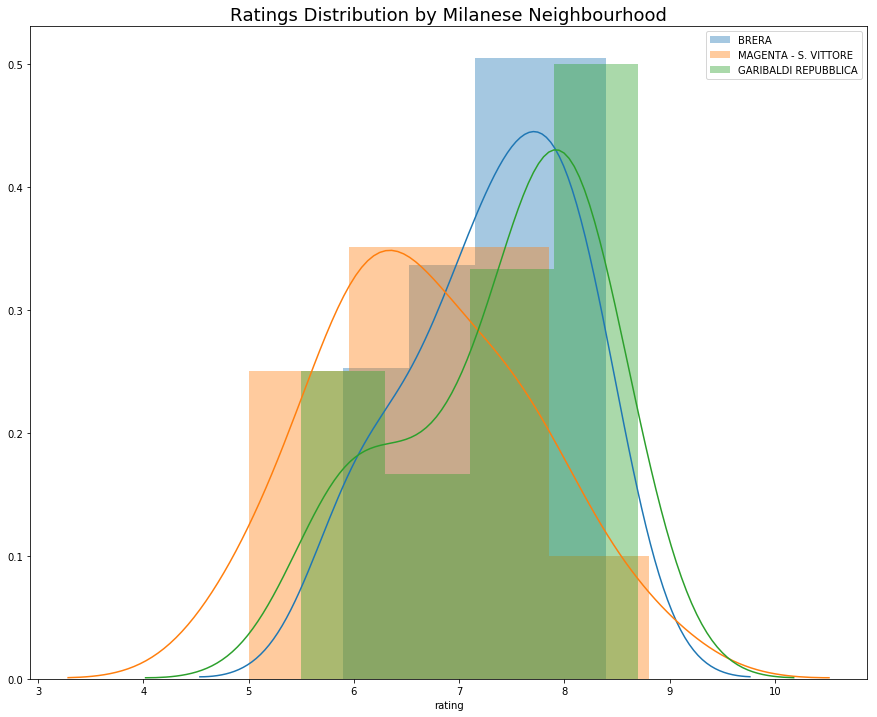

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(15,12))
ax= sns.distplot(data.loc[data['neighbourhood'] == 'BRERA']['rating'])
ax = sns.distplot(data.loc[data['neighbourhood'] == 'MAGENTA - S. VITTORE']['rating'])
ax = sns.distplot(data.loc[data['neighbourhood'] == 'GARIBALDI REPUBBLICA']['rating'])
ax.legend(['BRERA', 'MAGENTA - S. VITTORE', 'GARIBALDI REPUBBLICA'])
ax.set_title('Ratings Distribution by Milanese Neighbourhood', fontsize=18)
sns.set_style({'axes.spines.bottom': False,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False})

In [39]:
data[data['neighbourhood'] == 'GARIBALDI REPUBBLICA'].shape

(30, 134)

In [40]:
print(sorted(data['rating'].unique()))
print(len(data['rating'].unique()))


[5.0, 5.1, 5.5, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.6, 8.7, 8.8]
33


In [41]:
!pip install colour
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),50))
ratings_list = data['rating']
colors_list=[]
for rating in ratings_list:
    colors_list.append(str(colors[round(rating*10 - 50)]))
len(colors_list)
print(colors_list)

['#d68b00', '#89b100', '#93b400', '#77ac00', '#c3b700', '#a6b900', '#66a700', '#a6b900', '#d09900', '#a6b900', '#e26600', '#80af00', '#c9ac00', '#6fa900', '#e85500', '#cea000', '#babe00', '#c6b200', '#9cb600', '#e55e00', '#469d00', '#db7d00', '#cea000', '#dd7500', '#e85500', '#fc0a00', '#d88400', '#77ac00', '#dd7500', '#d68b00', '#b0bc00', '#b0bc00', '#e85500', '#cba600', '#ed4400', '#e55e00', 'red', '#6fa900', '#b0bc00', '#ea4c00', '#80af00', '#b0bc00', '#89b100', '#b0bc00', '#4e9f00', '#9cb600', '#c3b700', '#93b400', '#9cb600', '#e55e00', '#e26600', '#cea000', '#6fa900', '#89b100', '#e06e00', '#d09900', '#c3b700', '#c3b700', '#e85500', '#c1bd00', '#93b400', '#9cb600', '#e26600', '#d88400', '#56a200', '#80af00', '#cba600', '#f23100', '#66a700', '#6fa900']


In [42]:
from folium.plugins import MarkerCluster
from folium.features import Choropleth

restaurants_map = folium.Map(location=[45.473538, 9.181776], tiles="cartodbdark_matter", zoom_start=14)

for index, row in data.iterrows():
    print(index)
    popup = data.loc[index]['name_y'] + ', rated: ' + str(data.loc[index]['rating'])
    folium.Marker([data.loc[index]['location.lat_y'], data.loc[index]['location.lng_y']], popup=popup, icon=folium.Icon(icon='glyphicon-cutlery', color='white', icon_color=colors_list[index])).add_to(restaurants_map)


Choropleth(geo_data='nilzone_lnglat.geojson', fill_color='gray', line_color='green', fill_opacity=0.4,
            line_weight=3).add_to(restaurants_map)
restaurants_map

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [43]:
data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

Index(['beenHere.count', 'beenHere.lastCheckinExpiredAt',
       'beenHere.unconfirmedCount', 'bestPhoto.createdAt', 'bestPhoto.height',
       'bestPhoto.width', 'colors.algoVersion', 'colors.highlightColor.value',
       'colors.highlightTextColor.value', 'contact.facebook', 'contact.phone',
       'createdAt', 'hereNow.count', 'inbox.count', 'likes.count',
       'listed.count', 'location.lat_y', 'location.lng_y',
       'location.postalCode_y', 'page.pageInfo.links.count', 'page.user.bio',
       'page.user.contact.facebook', 'page.user.id', 'page.user.tips.count',
       'pageUpdates.count', 'parent.location.lat', 'parent.location.lng',
       'parent.location.postalCode', 'photos.count', 'price.tier', 'rating',
       'ratingSignals', 'reasons.count', 'specials.count', 'stats.tipCount',
       'storeId', 'tips.count'],
      dtype='object')

In [44]:
red = Color("red")
colors = list(red.range_to(Color("green"),50))
ratings_list = data['rating']
colors_list=[]
for rating in ratings_list:
    colors_list.append(str(colors[round(rating*10 - 50)]))
len(colors_list)
print(colors_list)

['#d68b00', '#89b100', '#93b400', '#77ac00', '#c3b700', '#a6b900', '#66a700', '#a6b900', '#d09900', '#a6b900', '#e26600', '#80af00', '#c9ac00', '#6fa900', '#e85500', '#cea000', '#babe00', '#c6b200', '#9cb600', '#e55e00', '#469d00', '#db7d00', '#cea000', '#dd7500', '#e85500', '#fc0a00', '#d88400', '#77ac00', '#dd7500', '#d68b00', '#b0bc00', '#b0bc00', '#e85500', '#cba600', '#ed4400', '#e55e00', 'red', '#6fa900', '#b0bc00', '#ea4c00', '#80af00', '#b0bc00', '#89b100', '#b0bc00', '#4e9f00', '#9cb600', '#c3b700', '#93b400', '#9cb600', '#e55e00', '#e26600', '#cea000', '#6fa900', '#89b100', '#e06e00', '#d09900', '#c3b700', '#c3b700', '#e85500', '#c1bd00', '#93b400', '#9cb600', '#e26600', '#d88400', '#56a200', '#80af00', '#cba600', '#f23100', '#66a700', '#6fa900']


In [46]:
def get_categories(unprocessed_string):
    my_list = []
    for i, x in enumerate(unprocessed_string.split("'")):
        if x == 'name':
            my_list.append(unprocessed_string.split("'")[i+2])
    return my_list

In [47]:
data['categories_list'] = data['categories'].apply(get_categories)

In [48]:
def categories_dummies(data):
    for index, row in data.iterrows():
        for item in data.loc[index]['categories_list']:
            data.iloc[index]['is_' + item] = np.nan
            if item in data.loc[index]['categories_list']:
                data.loc[index, 'is_' + item] = 1
            else:
                data.loc[index, 'is_' + item] = 0

In [49]:
get_categories(data['categories'][0])

['Cocktail Bar', 'Café', 'Bar']

In [50]:
categories_dummies(data)

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/administrator/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


In [51]:
data.is_Bar.unique()

array([ 1., nan])

In [52]:
data.loc[index]['categories_list']

['Italian Restaurant']

In [53]:
data['is_Italian Restaurant']

0     NaN
1     NaN
2     NaN
3     1.0
4     NaN
5     1.0
6     1.0
7     NaN
8     1.0
9     NaN
10    NaN
11    1.0
12    1.0
13    NaN
14    1.0
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    1.0
25    NaN
26    1.0
27    NaN
28    1.0
29    1.0
     ... 
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
45    1.0
46    NaN
47    NaN
48    NaN
49    NaN
50    NaN
51    1.0
52    NaN
53    NaN
54    NaN
55    NaN
56    1.0
57    NaN
58    NaN
59    NaN
60    NaN
61    1.0
62    NaN
63    NaN
64    NaN
65    1.0
66    1.0
67    NaN
68    NaN
69    1.0
Name: is_Italian Restaurant, Length: 70, dtype: float64

In [54]:
for c in data.columns:
    print(c)

id
neighbourhood
referralId
allowMenuUrlEdit
attributes.groups
beenHere.count
beenHere.lastCheckinExpiredAt
beenHere.marked
beenHere.unconfirmedCount
bestPhoto.createdAt
bestPhoto.height
bestPhoto.id
bestPhoto.prefix
bestPhoto.source.name
bestPhoto.source.url
bestPhoto.suffix
bestPhoto.visibility
bestPhoto.width
canonicalUrl
categories
colors.algoVersion
colors.highlightColor.photoId
colors.highlightColor.value
colors.highlightTextColor.photoId
colors.highlightTextColor.value
contact.facebook
contact.facebookName
contact.facebookUsername
contact.formattedPhone
contact.instagram
contact.phone
contact.twitter
createdAt
description
dislike
hereNow.count
hereNow.groups
hereNow.summary
hierarchy
hours.dayData
hours.isLocalHoliday
hours.isOpen
hours.richStatus.entities
hours.richStatus.text
hours.status
hours.timeframes
inbox.count
inbox.items
likes.count
likes.groups
likes.summary
listed.count
listed.groups
location.address_y
location.cc
location.city
location.country
location.crossStreet_y

In [55]:
data_0 = data[['name_y', 'id', 'neighbourhood', 'rating', 'price.tier',
             'location.lat_y', 'location.lng_y', 'is_Cocktail Bar',
             'is_Café', 'is_Bar', 'is_Ice Cream Shop', 'is_Restaurant',
             'is_Italian Restaurant', 'is_Bakery', 'is_Pizza Place',
             'is_French Restaurant', 'is_Lounge', 'is_Seafood Restaurant',
             'is_Mediterranean Restaurant', 'is_Diner', 'is_Bistro',
             'is_Breakfast Spot', 'is_American Restaurant', 'is_Pie Shop',
             'is_Snack Place', 'is_Museum', 'is_Dessert Shop',
             'is_Chocolate Shop', 'is_Art Gallery', 'is_Convention Center',
             'is_Gourmet Shop', 'is_Food & Drink Shop', 'is_Bookstore',
             'is_Coffee Shop', 'is_Boutique', 'is_Gastropub', 'is_Pub',
             'is_Vegetarian / Vegan Restaurant', 'is_Mexican Restaurant', 
             'is_Brewery', 'is_Burger Joint', 'is_Thai Restaurant',
             'is_Ramen Restaurant', 'is_Emilia Restaurant', 'is_Piadineria']]

In [56]:
data_0

,name_y,id,neighbourhood,rating,price.tier,location.lat_y,location.lng_y,is_Cocktail Bar,is_Café,is_Bar,...,is_Gastropub,is_Pub,is_Vegetarian / Vegan Restaurant,is_Mexican Restaurant,is_Brewery,is_Burger Joint,is_Thai Restaurant,is_Ramen Restaurant,is_Emilia Restaurant,is_Piadineria
0,Bar Brera,4c3a2741ae2da593bfc503c6,BRERA,6.6,2.0,45.472260,9.187459,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amorino,4bb5f3c62ea1952143ecaa2f,BRERA,8.0,2.0,45.472052,9.185834,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bioesserì,55e1c0b1498e7d11ef90db84,BRERA,7.9,3.0,45.473016,9.188367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nabucco,4b05887ef964a520aac922e3,BRERA,8.2,3.0,45.472159,9.186968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Panificio Pattini,4ceff84c8604a1cdb70c00c1,BRERA,7.3,1.0,45.473762,9.187213,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ristorante Pizzeria Il Kaimano,4cde8cf1f8cdb1f71abf8b12,BRERA,7.7,2.0,45.472101,9.186232,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Antica Osteria Stendhal,4c080806bbc676b0e6e545d5,BRERA,8.4,3.0,45.473978,9.187678,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gelateria Solferino,4b058879f964a520fec722e3,BRERA,7.7,1.0,45.474653,9.186998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Botinero,4dfa70cc14959516a964ef3b,BRERA,6.8,3.0,45.474244,9.187898,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Fioraio Bianchi Caffè,4c0d639898102d7f511ae206,BRERA,7.7,3.0,45.475294,9.189395,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
data_0.describe()

,rating,price.tier,location.lat_y,location.lng_y,is_Cocktail Bar,is_Café,is_Bar,is_Ice Cream Shop,is_Restaurant,is_Italian Restaurant,...,is_Gastropub,is_Pub,is_Vegetarian / Vegan Restaurant,is_Mexican Restaurant,is_Brewery,is_Burger Joint,is_Thai Restaurant,is_Ramen Restaurant,is_Emilia Restaurant,is_Piadineria
count,70.000000,59.000000,70.000000,70.000000,4.0,20.0,3.0,6.0,4.0,22.0,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,7.170000,2.118644,45.474449,9.183846,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.948737,0.811230,0.007932,0.007883,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000000,1.000000,45.462193,9.168347,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,6.325000,1.000000,45.465699,9.173652,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,7.300000,2.000000,45.475301,9.187383,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,7.900000,3.000000,45.481802,9.188968,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,8.800000,3.000000,45.483727,9.193710,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [58]:
data_0.iloc[0]

name_y                                             Bar Brera
id                                  4c3a2741ae2da593bfc503c6
neighbourhood                                          BRERA
rating                                                   6.6
price.tier                                                 2
location.lat_y                                       45.4723
location.lng_y                                       9.18746
is_Cocktail Bar                                            1
is_Café                                                    1
is_Bar                                                     1
is_Ice Cream Shop                                        NaN
is_Restaurant                                            NaN
is_Italian Restaurant                                    NaN
is_Bakery                                                NaN
is_Pizza Place                                           NaN
is_French Restaurant                                     NaN
is_Lounge               

In [59]:
data_0 = pd.get_dummies(data=data_0, columns=['neighbourhood'])
data_0.dtypes

name_y                                 object
id                                     object
rating                                float64
price.tier                            float64
location.lat_y                        float64
location.lng_y                        float64
is_Cocktail Bar                       float64
is_Café                               float64
is_Bar                                float64
is_Ice Cream Shop                     float64
is_Restaurant                         float64
is_Italian Restaurant                 float64
is_Bakery                             float64
is_Pizza Place                        float64
is_French Restaurant                  float64
is_Lounge                             float64
is_Seafood Restaurant                 float64
is_Mediterranean Restaurant           float64
is_Diner                              float64
is_Bistro                             float64
is_Breakfast Spot                     float64
is_American Restaurant            

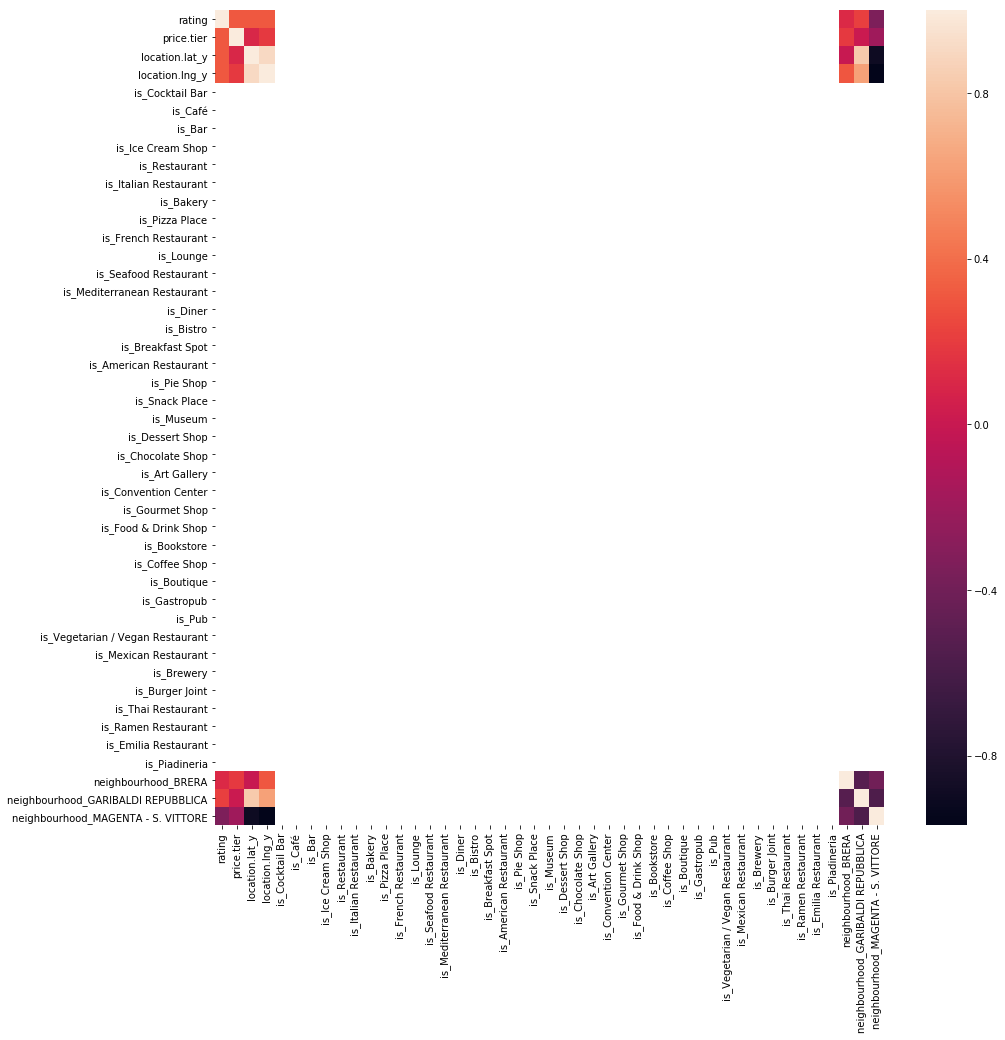

In [60]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
ax = sns.heatmap(data_0.corr())

In [61]:
corr_matrix = data_0[['rating', 'is_Cocktail Bar',
             'is_Café', 'is_Bar', 'is_Ice Cream Shop', 'is_Restaurant',
             'is_Italian Restaurant', 'is_Bakery', 'is_Pizza Place',
             'is_French Restaurant', 'is_Lounge', 'is_Seafood Restaurant',
             'is_Mediterranean Restaurant', 'is_Diner', 'is_Bistro',
             'is_Breakfast Spot', 'is_American Restaurant', 'is_Pie Shop',
             'is_Snack Place', 'is_Museum', 'is_Dessert Shop',
             'is_Chocolate Shop', 'is_Art Gallery', 'is_Convention Center',
             'is_Gourmet Shop', 'is_Food & Drink Shop', 'is_Bookstore',
             'is_Coffee Shop', 'is_Boutique', 'is_Gastropub', 'is_Pub',
             'is_Vegetarian / Vegan Restaurant', 'is_Mexican Restaurant', 
             'is_Brewery', 'is_Burger Joint', 'is_Thai Restaurant',
             'is_Ramen Restaurant', 'is_Emilia Restaurant', 'is_Piadineria', 'neighbourhood_BRERA',
'neighbourhood_GARIBALDI REPUBBLICA', 'neighbourhood_MAGENTA - S. VITTORE']].corr()
corr_matrix

,rating,is_Cocktail Bar,is_Café,is_Bar,is_Ice Cream Shop,is_Restaurant,is_Italian Restaurant,is_Bakery,is_Pizza Place,is_French Restaurant,...,is_Mexican Restaurant,is_Brewery,is_Burger Joint,is_Thai Restaurant,is_Ramen Restaurant,is_Emilia Restaurant,is_Piadineria,neighbourhood_BRERA,neighbourhood_GARIBALDI REPUBBLICA,neighbourhood_MAGENTA - S. VITTORE
rating,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111523,0.214529,-0.339892
is_Cocktail Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Café,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Ice Cream Shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Italian Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Bakery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_Pizza Place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_French Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
sorted(corr_matrix['rating'], reverse=True)

[1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.21452907547288103,
 0.11152304230223689,
 -0.33989243640034045]

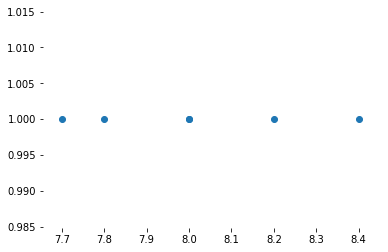

In [63]:
plt.scatter(data_0['rating'], data_0['is_Ice Cream Shop'])

In [64]:
data_0.dtypes

name_y                                 object
id                                     object
rating                                float64
price.tier                            float64
location.lat_y                        float64
location.lng_y                        float64
is_Cocktail Bar                       float64
is_Café                               float64
is_Bar                                float64
is_Ice Cream Shop                     float64
is_Restaurant                         float64
is_Italian Restaurant                 float64
is_Bakery                             float64
is_Pizza Place                        float64
is_French Restaurant                  float64
is_Lounge                             float64
is_Seafood Restaurant                 float64
is_Mediterranean Restaurant           float64
is_Diner                              float64
is_Bistro                             float64
is_Breakfast Spot                     float64
is_American Restaurant            

In [65]:
data_0

,name_y,id,rating,price.tier,location.lat_y,location.lng_y,is_Cocktail Bar,is_Café,is_Bar,is_Ice Cream Shop,...,is_Mexican Restaurant,is_Brewery,is_Burger Joint,is_Thai Restaurant,is_Ramen Restaurant,is_Emilia Restaurant,is_Piadineria,neighbourhood_BRERA,neighbourhood_GARIBALDI REPUBBLICA,neighbourhood_MAGENTA - S. VITTORE
0,Bar Brera,4c3a2741ae2da593bfc503c6,6.6,2.0,45.472260,9.187459,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,Amorino,4bb5f3c62ea1952143ecaa2f,8.0,2.0,45.472052,9.185834,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,Bioesserì,55e1c0b1498e7d11ef90db84,7.9,3.0,45.473016,9.188367,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,Nabucco,4b05887ef964a520aac922e3,8.2,3.0,45.472159,9.186968,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,Panificio Pattini,4ceff84c8604a1cdb70c00c1,7.3,1.0,45.473762,9.187213,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
5,Ristorante Pizzeria Il Kaimano,4cde8cf1f8cdb1f71abf8b12,7.7,2.0,45.472101,9.186232,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
6,Antica Osteria Stendhal,4c080806bbc676b0e6e545d5,8.4,3.0,45.473978,9.187678,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
7,Gelateria Solferino,4b058879f964a520fec722e3,7.7,1.0,45.474653,9.186998,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
8,Botinero,4dfa70cc14959516a964ef3b,6.8,3.0,45.474244,9.187898,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
9,Fioraio Bianchi Caffè,4c0d639898102d7f511ae206,7.7,3.0,45.475294,9.189395,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
